In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from scripts.mask_maps import mask_maps
from scripts.patch_mask import patch_mask

In [2]:
# Parameters
nside = 256 
ra_min, ra_max = -60.0, 60.0   # degrees
dec_min, dec_max = -75.0, -10.0  # degrees
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
# n_bins=10
bin_width=10

In [3]:
import pymaster as nmt
def compute_decoupled_cl( maps: np.ndarray, masks:np.ndarray, l_max:int, n_freq:int)-> np.ndarray:
    """
    Compute the power spectra using NaMaster for a set of frequency maps.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - X: flag to indicate if the input maps are masked
    - nsides: resolution parameter for the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels

    Returns:
    - p_cl: raw power spectrum (coupled)
    - matrix: mode coupling matrix
    - cldec: decoupled power spectrum
    """

    cldec = np.zeros((l_max//bin_width, n_freq, n_freq))
    
    
    # Define a NaMaster binning scheme (no binning)
    b = nmt.NmtBin.from_lmax_linear(l_max, bin_width)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print ("processing map %d" % i)
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)
            
            # Define the masked fields for the two maps
            f_i = nmt.NmtField(masks, [maps[i, :]], lmax=l_max) 
            f_j = nmt.NmtField( masks, [maps[j, :]], lmax=l_max) 
            
            cldec[:,i,j]=nmt.compute_full_master(f_i, f_j, b)

            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
    
    return leff,n_bins,cldec

In [4]:
b = nmt.NmtBin.from_lmax_linear(lmax, bin_width)
n_bins = b.get_n_bands()
leff = b.get_effective_ells()

In [5]:
dec_fgds=np.load('/home/iloveorcas/SMICA_Paper/results/dec_fgds.npy')
dec_hi=np.load('/home/iloveorcas/SMICA_Paper/results/dec_hi.npy')
dec_noise=np.load('/home/iloveorcas/SMICA_Paper/results/dec_noise.npy')
dec_sky=np.load('/home/iloveorcas/SMICA_Paper/results/dec_sky.npy')

Text(0.5, 0, '$\\ell$')

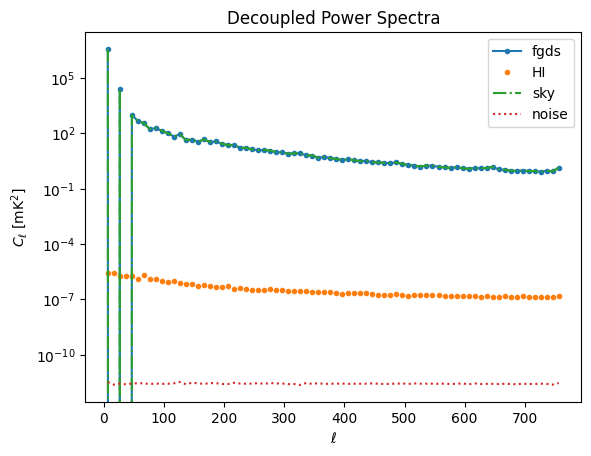

In [6]:
plt.plot(leff,dec_fgds[:,0,0], '.-',label='fgds')

plt.plot(leff,dec_hi[:,0,0], '.', label='HI')
plt.plot(leff,dec_sky[:,0,0], '-.', label='sky')
plt.plot(leff,dec_noise[:,0,0], ':', label='noise')
# plt.plot(ells,cl_hi[:,0,0], label='hi cl unmasked')
# plt.plot(ells, hi_cl_test, label='hi cl test')
plt.yscale('log')
# plt.loglog()
# plt.plot( dec_fgds[5:,0,0]-dec_hi[5:,0,0], label='fgds - HI')
# plt.loglog()
plt.legend()
plt.title('Decoupled Power Spectra')
plt.ylabel(r'$C_\ell$ [mK$^2$]')
plt.xlabel(r'$\ell$')

## Make sure empirical covariance is PSD

In [51]:
c_hat=np.zeros((n_bins, nfreqs, nfreqs)) #clip any eigenvalues that are negative and put to zerp
for b in range(n_bins):
    
    cov = 0.5 * (dec_sky[b] + dec_sky[b].T) #symmetric or Hermitian?

    # Eigen-decomposition (since it's symmetric, use eigh)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Zero out negative eigenvalues
    eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
    
    epsilon=1e-12

    # Reconstruct the covariance matrix
    c_hat[b] = (eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T)#+ epsilon*np.identity(nfreqs) 

## PCA

In [303]:
def pca(empirical, r, f):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-17 #pass as argument depending on power ratio

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b


In [304]:
factor=1
_,F_pca, P_b_pca = pca(c_hat,r, factor)
# F_pca, P_b_pca = guess_params(nfreqs, n_bins,r)
# e,F_pca, P_b_pca = pca_extended_random_fill(c_hat,5,2)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
print(params_pca.shape)

(54, 3)
(76, 3, 3)
(846,)


## Build Model covariance

In [306]:
def model_covariance(F, P_b,C_HI,C_noise):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:] + C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b
c_model= model_covariance(F_pca, P_b_pca,dec_hi,dec_noise)

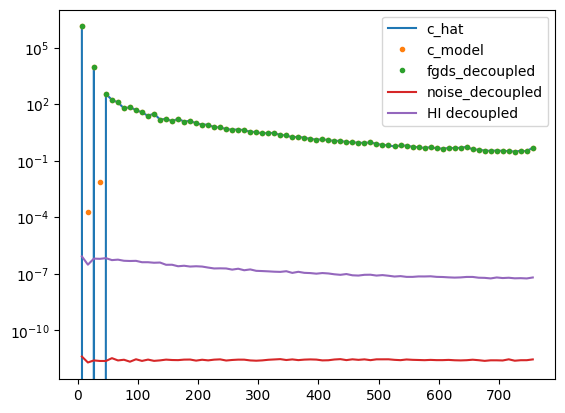

In [307]:
plt.plot(leff,dec_sky[:,10,10], label='c_hat')
plt.plot(leff,c_model[:,10,10],'.', label='c_model')
plt.plot(leff,dec_fgds[:,10,10],'.', label='fgds_decoupled')
plt.plot(leff,dec_noise[:,10,10], label='noise_decoupled')
plt.plot(leff,dec_hi[:,10,10], label='HI decoupled')
plt.yscale('log')
plt.legend()

In [309]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(P_b_pca))

Is model PSD? True


## define smica function and its jacobian

In [ ]:
def smica(params):
    # unpack
    nF = nfreqs*(r-1)
    F_free = params[:nF].reshape(nfreqs, r-1)

    #rebuild full F
    F = np.zeros((nfreqs, r))
    F[:,0] = 1.0
    F[:,1:] = F_free

    #unpack L_b
    L_b = params[nF:].reshape(n_bins, r, r)

    cost = 0.0
    for b in range(n_bins):
        P_b = L_b[b] @ L_b[b].T                       # covariance
        R = dec_hi[b] + dec_noise[b] + F @ P_b @ F.T  # model covariance

        Rinv = np.linalg.pinv(R)
        sign,logdet = np.linalg.slogdet(c_hat[b] @ Rinv)
        cost += -logdet + np.trace(c_hat[b] @ Rinv) - nfreqs

    return cost


In [438]:
def jacobian(params):
    nF = nfreqs*(r-1)
    F_free = params[:nF].reshape(nfreqs, r-1)

    # rebuild F
    F = np.zeros((nfreqs, r))
    F[:,0] = 1.0
    F[:,1:] = F_free

    L_b = params[nF:].reshape(n_bins, r, r)

    grad_F = np.zeros_like(F)
    grad_L = np.zeros_like(L_b)

    for b in range(n_bins):
        P_b = L_b[b] @ L_b[b].T #psd
        
        R = dec_hi[b] + dec_noise[b] + F @ P_b @ F.T

        Rinv = np.linalg.pinv(R)
        Delta = Rinv - Rinv @ c_hat[b] @ Rinv

        # d phi / dP_b
        Gp = F.T @ (Delta @ F)      # (r,r)

        # chain rule: P = L L^T
        grad_L[b] = 2*np.tril(Gp @ L_b[b])

        # d phi / dF
        grad_F += 2 * Delta @ (F @ P_b)

    # remove gradient for fixed column F[:,0]
    grad_F[:,0] = 0.0

    # flatten only free part of F
    grad_F_free = grad_F[:,:].reshape(-1)

    return np.concatenate([grad_F_free, grad_L.flatten()])


In [439]:
pivot = 0
d0 = F_pca[pivot, 0]

# new full F (with column 0 = 1)
F_new = F_pca / d0            # broadcasts automatically
F_free_init = F_new[:, 1:]    # shape (nfreqs, r-1) build the full vector inside smica

Dinv = np.diag([1/d0] + [1]*(r-1))

L_new = np.zeros_like(P_b_pca)
for b in range(n_bins):
    P_old = P_b_pca[b]
    P_new = Dinv @ P_old @ Dinv
    P_new = 0.5*(P_new + P_new.T)
    eps = 1e-17*np.trace(P_new)/r
    L_new[b] = np.linalg.cholesky(P_new + eps*np.eye(r))
params_new = np.concatenate([
    F_free_init.flatten(),
    L_new.flatten()
])
c0 = smica(params_new)
g0 = jacobian(params_new)
print("Initial cost:", c0)
print("Initial grad norm:", np.linalg.norm(g0))


Initial cost: 38378.92444841565
Initial grad norm: 79257168.04612587


In [448]:
from scipy import optimize

res = optimize.minimize(
    smica,
    x0=params_new,
    # args=(dec_hi, dec_noise, c_dec, n_bins, nfreqs,r),
    method='L-BFGS-B',
    # constraints=constraint,
    jac=jacobian,
    options={'disp': True, 'maxiter':3000, 'gtol':1e-10, 'verbose':3, 'ftol':1e-8, 'maxls':3000}
)
from pprint import pprint
pprint(res)

/tmp/ipykernel_198571/1752591837.py:3: OptimizeWarning: Unknown solver options: verbose
  res = optimize.minimize(


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 38370.83000569779
        x: [-8.864e-01 -8.189e-01 ... -1.610e+00  2.315e+00]
      nit: 5
      jac: [ 0.000e+00 -5.932e+05 ...  4.409e-03  7.354e-01]
     nfev: 202
     njev: 202
 hess_inv: <792x792 LbfgsInvHessProduct with dtype=float64>


In [441]:
result=res.x
print(result.shape)
# P_b_out = result[nfreqs*r:].reshape((n_bins,r,r))
L_b_out = result[nfreqs*(r-1):].reshape((n_bins, r, r))
P_b_out = np.einsum("bij,bkj->bik", L_b_out, L_b_out)
F_out = result[:nfreqs*r].reshape((nfreqs, r))
print(P_b_out.shape)
print(F_out.shape)

C_result=np.zeros_like(dec_sky)
for b in range(n_bins):
    
    C_result[b]=np.dot(F_out, np.dot(P_b_out[b], F_out.T))
np.all(np.linalg.eigvals(C_result) >=0)


(792,)
(76, 3, 3)
(54, 3)


np.False_

In [442]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol)  
print("Is model PSD?", is_psd(P_b_out))

Is model PSD? True


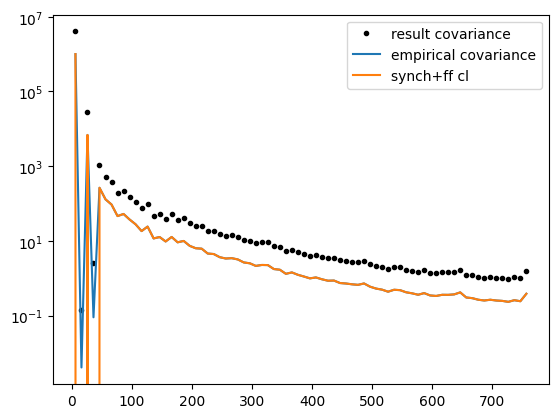

In [443]:
f=13
plt.plot(leff,C_result[:,f,f],'k.', label="result covariance")
plt.plot(leff,c_hat[:,f,f], label="empirical covariance")
# plt.plot(leff,c_model[:,f,f], label="model covaraince")
# plt.plot(leff, dec_hi[:,f,f], label="hi covaraince")
# plt.plot(leff,dec_noise[:,f,f], label="noise covariance")
plt.plot(leff, dec_fgds[:,f,f], label="synch+ff cl")
plt.yscale('log')
plt.legend()